In [2]:
import networkx as nx
import pandas as pd
import pysam
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/miaocj/docker_dir/kNN-overlap-finder/scripts')
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges
from plots import plot_read_graph

/home/miaocj/docker_dir/kNN-overlap-finder/scripts/../lib


In [27]:
def get_bam_stat_df(bam_file):
    bam = pysam.AlignmentFile(bam_file, "rb")
    df_rows = []
    for i, seg in enumerate(bam.fetch("chr6", 28476949, 34231258)):
        if seg.is_reverse:
            strand = "-"  # 反向链
        else:
            strand = "+"  # 正向链
        if seg.has_tag("NM"):
            mismatch = seg.get_tag("NM")
        else:
            mismatch = 0 
        row = dict(
            segment_id=i,
            reference_name=seg.reference_name,
            reference_start=seg.reference_start,
            reference_end=seg.reference_end,
            reference_strand = strand,
            mismatch=mismatch,
            query_name=seg.query_name,
            query_alignment_start=seg.query_alignment_start,
            query_length=seg.query_length,
            query_alignment_length=seg.query_alignment_length,
            mapping_quality=seg.mapping_quality,
        )
        df_rows.append(row)
    df = pd.DataFrame(df_rows)
    return df

df = get_bam_stat_df("/home/miaocj/docker_dir/kNN-overlap-finder/data/real_reads/CHM13/real_cyclone/all_reads.bam")
df['percentage'] =df['query_alignment_length']/df['query_length']

max_indices = df.groupby('query_name')['percentage'].idxmax()
result = df.loc[max_indices]
meta_df = result[result.percentage>0.9]
all_reads_num = len(result['query_name'].tolist())

bad_query = result[result.percentage<=0.9]['query_name'].tolist()
bad_query_align = df[df.query_name.isin(bad_query)].groupby('query_name').size().reset_index()
bad_query_num = bad_query_align.shape[0]
bad_in_all = bad_query_num/all_reads_num
lines_number = bad_query_align[bad_query_align.loc[:,0]>1].shape[0]
per = lines_number/bad_query_num
print('There are %d(%f) reads do not have >90%% percentage and %d(%f) of them have more than one alignment.'%(bad_query_num,bad_in_all,lines_number,per))
  
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

There are 364(0.034016) reads do not have >90% percentage and 0(0.000000) of them have more than one alignment.
1225.72893081761


(10337, 151400, 19857, 2)

In [33]:
#meta_df = pd.read_table('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/real_cyclone/kmer_k16/metadata.tsv.gz').reset_index()
meta_df = pd.read_table('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/HLA/real_cyclone/kmer_k16/metadata.tsv.gz').reset_index()

def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

579.3011512044113


(20676, 606600, 40462, 2)

In [34]:
import collections
from typing import Type, Sequence, Mapping, Any, Collection, MutableMapping
from dataclasses import dataclass
import numpy as np
from numpy import ndarray
import networkx as nx
from intervaltree import Interval, IntervalTree
def get_interval_trees(
    read_intervals
):
    tree_dict = collections.defaultdict(IntervalTree)
    for read, intervals in read_intervals.items():
        for intv in intervals:
            tree = tree_dict[intv.chromosome]
            tree.addi(intv.start, intv.end, read)
    return tree_dict
trees = get_interval_trees(read_intervals=read_intervals)
graph = nx.Graph()
contained_reads = set()
for read_0, intervals in read_intervals.items():
    parent_reads = set()
    for intv in intervals:
        tree = trees[intv.chromosome]
        start_0 = intv.start
        end_0 = intv.end
        for intv_1 in tree.overlap(start_0, end_0):
            read_1 = intv_1.data
            if read_1 == read_0:
                continue
            start_1, end_1 = intv_1.begin, intv_1.end
            if start_1 < start_0 and end_1 > end_0:
                parent_reads.add(read_1)
            if graph.has_edge(read_0, read_1):
                continue
            overlap_size = max(0, min(end_0, end_1) - max(start_0, start_1))
            left_overhang_size = abs(start_0 - start_1)
            left_overhang_node = read_0 if start_0 <= start_1 else read_1
            right_overhang_size = abs(end_0 - end_1)
            right_overhang_node = read_0 if end_0 >= end_1 else read_1
            graph.add_edge(
                read_0,
                read_1,
                overlap_size=overlap_size,
                left_overhang_size=left_overhang_size,
                left_overhang_node=left_overhang_node,
                right_overhang_size=right_overhang_size,
                right_overhang_node=right_overhang_node,
                redundant=True,
            )

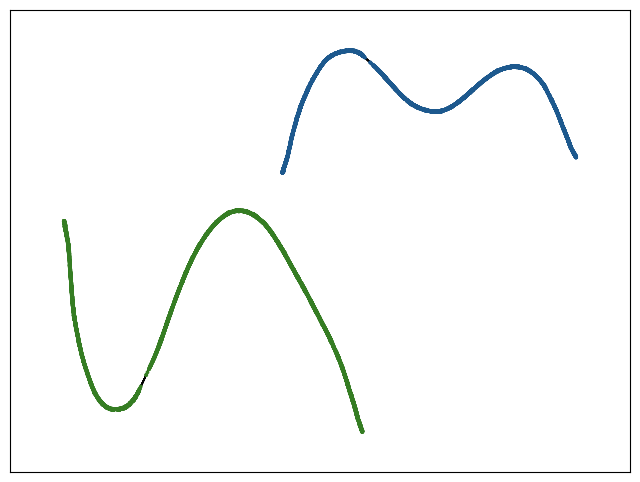

In [35]:

def get_graphviz_layout(graph, method="neato", figsize=(8, 6), seed=43, **kw):
    fig_width, fig_height = figsize
    graph_attributes = dict(
        dim=2, dimen=2, size=f'"{fig_width},{fig_height}"', start=seed, smoothing="none"
    )
    graph_attributes.update(kw)
    args = " ".join(f"-G{key}={value}" for key, value in graph_attributes.items())
    pos = nx.nx_agraph.graphviz_layout(graph, prog=method, args=args)
    return pos

pos = get_graphviz_layout(
        graph=graph, figsize=(8, 6), seed=43, method="sfdp"
    )

fig, ax = plt.subplots(figsize=(8, 6))

BLUE = (29 / 255, 89 / 255, 142 / 255, 1)
GREEN = (53 / 255, 125 / 255, 35 / 255, 1)
ORANGE = (252 / 255, 177 / 255, 3 / 255, 1)

# Node colors
node_colors = []
for node in graph.nodes:
    if len(graph[node]) == 0:
        color = ORANGE
    elif meta_df.at[node, "reference_strand"] == "+":
        color = BLUE
    elif meta_df.at[node, "reference_strand"] == "-":
        color = GREEN
    else: 
        raise ValueError()
    node_colors.append(color)

# Plot
nx.draw_networkx(
    graph,
    ax=ax,
    pos=pos,
    with_labels=False,
    node_size=3,
    #edge_color=edge_colors,
    node_color=node_colors,
)